In [17]:
import dockstring
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import gzip
from itertools import chain

from rdkit import Chem
from rdkit.Chem.SaltRemover import SaltRemover
from rdkit.Chem import Descriptors
from rdkit.Chem import Lipinski

from rdkit import RDLogger

RDLogger.DisableLog('rdApp.error')

In [22]:
with gzip.open('actives_final.sdf.gz') as sdf:
    supp_actives = Chem.ForwardSDMolSupplier(sdf)
    actives = [[mol, 'actives'] for mol in supp_actives if mol]

with gzip.open('decoys_final.sdf.gz') as sdf:
    supp_decoys = Chem.ForwardSDMolSupplier(sdf)
    decoys = [[mol, 'decoys'] for mol in supp_decoys if mol]

df_ac = pd.DataFrame(actives, columns=['Mol', 'Source'])
df_de = pd.DataFrame(decoys, columns=['Mol', 'Source'])

df = pd.concat((df_ac, df_de), ignore_index=True)
df

,Mol,Source
0,<rdkit.Chem.rdchem.Mol object at 0x7f54eaf12f30>,actives
1,<rdkit.Chem.rdchem.Mol object at 0x7f54eafa8170>,actives
2,<rdkit.Chem.rdchem.Mol object at 0x7f54ead7d800>,actives
3,<rdkit.Chem.rdchem.Mol object at 0x7f54eb39db20>,actives
4,<rdkit.Chem.rdchem.Mol object at 0x7f54ead7b080>,actives
...,...,...
29121,<rdkit.Chem.rdchem.Mol object at 0x7f54ea803670>,decoys
29122,<rdkit.Chem.rdchem.Mol object at 0x7f54ea803710>,decoys
29123,<rdkit.Chem.rdchem.Mol object at 0x7f54ea8037b0>,decoys
29124,<rdkit.Chem.rdchem.Mol object at 0x7f54ea803850>,decoys


In [14]:
""" contribution from Hans de Winter """
def _InitialiseNeutralisationReactions():
    patts= (
        # Imidazoles
        ('[n+;H]','n'),
        # Amines
        ('[N+;!H0]','N'),
        # Carboxylic acids and alcohols
        ('[$([O-]);!$([O-][#7])]','O'),
        # Thiols
        ('[S-;X1]','S'),
        # Sulfonamides
        ('[$([N-;X2]S(=O)=O)]','N'),
        # Enamines
        ('[$([N-;X2][C,N]=C)]','N'),
        # Tetrazoles
        ('[n-]','[nH]'),
        # Sulfoxides
        ('[$([S-]=O)]','S'),
        # Amides
        ('[$([N-]C=O)]','N'),
        )
    return [(Chem.MolFromSmarts(x),Chem.MolFromSmiles(y,False)) for x,y in patts]

_reactions=None
def NeutraliseCharges(mol, reactions=None):
    global _reactions
    if reactions is None:
        if _reactions is None:
            _reactions=_InitialiseNeutralisationReactions()
        reactions=_reactions
    replaced = False
    for i,(reactant, product) in enumerate(reactions):
        while mol.HasSubstructMatch(reactant):
            replaced = True
            rms = Chem.ReplaceSubstructs(mol, reactant, product)
            mol = rms[0]
    return mol, replaced

In [18]:
_saltRemover = SaltRemover()
_inorganicPatt = Chem.MolFromSmarts("[!#6;!#7;!#8;!#16;!F;!Cl;!Br;!I]") # to remove compounds with unwanted atom types
_carbonPatt = Chem.MolFromSmarts("[#6]") # to remove compounds without carbon - inorganic

def standardize(mol):
    if mol.HasSubstructMatch(_carbonPatt):
        mol = _saltRemover(mol)
        if mol.GetNumAtoms()==0:
            return None
        else:
            mol, neutralized = NeutraliseCharges(mol)
            if mol.HasSubstructMatch(_inorganicPatt):
                return None
            else:
                # Sanitize mol, without sanitization some structures can't be drawn or fingerprinted
                Chem.SanitizeMol(mol) # add catch block?
                return mol
    else:
        return None

In [23]:
df['Mol'] = df['Mol'].apply(standardize)
df["Mol"].isna().sum()

104

In [24]:
df.dropna(inplace=True)
df

,Mol,Source
0,<rdkit.Chem.rdchem.Mol object at 0x7f54ea80a390>,actives
1,<rdkit.Chem.rdchem.Mol object at 0x7f54eafbde90>,actives
2,<rdkit.Chem.rdchem.Mol object at 0x7f54ea80a570>,actives
3,<rdkit.Chem.rdchem.Mol object at 0x7f54eb0496c0>,actives
4,<rdkit.Chem.rdchem.Mol object at 0x7f54ead7d8a0>,actives
...,...,...
29121,<rdkit.Chem.rdchem.Mol object at 0x7f54ea565440>,decoys
29122,<rdkit.Chem.rdchem.Mol object at 0x7f54ea5dc5d0>,decoys
29123,<rdkit.Chem.rdchem.Mol object at 0x7f54ea5dcb70>,decoys
29124,<rdkit.Chem.rdchem.Mol object at 0x7f54ea5dcf80>,decoys


In [25]:
df['Smiles'] = df['Mol'].apply(Chem.MolToSmiles)
df

,Mol,Source,Smiles
0,<rdkit.Chem.rdchem.Mol object at 0x7f54ea80a390>,actives,NC(CNc1ncc(-c2ccc3[nH]c(=O)oc3c2)s1)Cc1ccc(C(F...
1,<rdkit.Chem.rdchem.Mol object at 0x7f54eafbde90>,actives,NS(=O)(=O)c1ccc(N/N=C2\C(=O)Nc3ccc4n[nH]nc4c32...
2,<rdkit.Chem.rdchem.Mol object at 0x7f54ea80a570>,actives,NS(=O)(=O)c1ccc(N/N=C2\C(=O)Nc3ccc4n[nH]nc4c32...
3,<rdkit.Chem.rdchem.Mol object at 0x7f54eb0496c0>,actives,NS(=O)(=O)c1ccc(N/N=C2\C(=O)Nc3ccc4nn[nH]c4c32...
4,<rdkit.Chem.rdchem.Mol object at 0x7f54ead7d8a0>,actives,NS(=O)(=O)c1ccc(N/N=C2\C(=O)Nc3ccc4[nH]nnc4c32...
...,...,...,...
29121,<rdkit.Chem.rdchem.Mol object at 0x7f54ea565440>,decoys,CSc1ccc(C2C3=C(CCCC3=O)Nc3nn(-c4ccccc4)c(O)c32...
29122,<rdkit.Chem.rdchem.Mol object at 0x7f54ea5dc5d0>,decoys,CSc1ccc(C2C3=C(CCCC3=O)Nc3[nH]n(-c4ccccc4)c(=O...
29123,<rdkit.Chem.rdchem.Mol object at 0x7f54ea5dcb70>,decoys,O=C1CCCC2=C1C(c1cccc(Cl)c1)c1c([nH]n(-c3ccccc3...
29124,<rdkit.Chem.rdchem.Mol object at 0x7f54ea5dcf80>,decoys,Cc1cc(NC(=O)N2CCOC(c3ccc(F)c(Cl)c3)C2)ccc1N(C)C


In [26]:
def run_dockstring(target, ligand_smiles):
    """wrapper around Dockstring to return None if the process fails"""
    try:
        docking = target.dock(ligand_smiles)
        return docking
    except:
        return None, None

In [27]:
target = dockstring.load_target('CDK2')
run_dockstring(target, 'CCO')

/home/vmelichar/anaconda3/envs/PNL/lib/python3.7/site-packages/dockstring/utils.py:265: UserWarning: Incorrect rdkit version 2020.09.1 (expected 2021.03.*). You can still run docking, but be advised that the output may not match the dockstring dataset.
  warnings.warn(message=f"Incorrect rdkit version {rdkit.__version__} "


(-2.6,
 {'ligand': <rdkit.Chem.rdchem.Mol at 0x7f54eabb8170>,
  'affinities': [-2.6, -2.5, -2.4, -2.2, -2.1, -2.1, -2.1, -2.0, -1.9]})

In [28]:
df_sample = df.groupby('Source', group_keys=False).apply(lambda x: x.sample(min(len(x), 10)))
df_sample

,Mol,Source,Smiles
231,<rdkit.Chem.rdchem.Mol object at 0x7f54ea818df0>,actives,CCCOc1ccnc2[nH]cc(-c3ccnc(N)n3)c12
172,<rdkit.Chem.rdchem.Mol object at 0x7f54ea812850>,actives,Nc1ccc(-c2cc(Nc3ccc(S(N)(=O)=O)cc3)n[nH]2)cc1
636,<rdkit.Chem.rdchem.Mol object at 0x7f54eaedaad0>,actives,O=C(Cc1ccc(-c2ccccc2)c(F)c1)Nc1cc(C2CC2)n[nH]1
495,<rdkit.Chem.rdchem.Mol object at 0x7f54eac083a0>,actives,COc1ccc(-c2n[nH]c3c2C(=O)c2c(NC(=O)NNC(=O)Cc4c...
173,<rdkit.Chem.rdchem.Mol object at 0x7f54ea815490>,actives,NS(=O)(=O)c1ccc(/N=N\c2c(O)[nH]c3ccc4n[nH]nc4c...
140,<rdkit.Chem.rdchem.Mol object at 0x7f54ea820580>,actives,NS(=O)(=O)c1ccc(Nc2cc(-c3ccc([N+](=O)[O-])cc3)...
146,<rdkit.Chem.rdchem.Mol object at 0x7f54eb026490>,actives,CC(=O)Nc1c[nH]nc1-c1nc2ccccc2[nH]1
512,<rdkit.Chem.rdchem.Mol object at 0x7f54eb175440>,actives,CCOc1nc(NC(=O)Cc2cc(OC)ccc2OC)cc(N)c1C#N
484,<rdkit.Chem.rdchem.Mol object at 0x7f54ea81b330>,actives,CNC(=O)c1nn(C)c2c1C(C)(C)Cc1cnc(Nc3ccc(CN4CCN(...
314,<rdkit.Chem.rdchem.Mol object at 0x7f54ea809c10>,actives,CC(C)n1cnc2c(NC3CCCC3)nc(NCCCO)nc21


In [29]:
df_sample['rock1_dockstring_score'] = df_sample['Smiles'].apply(lambda x: run_dockstring(target, x)[0])
df_sample

/home/vmelichar/anaconda3/envs/PNL/lib/python3.7/site-packages/dockstring/utils.py:265: UserWarning: Incorrect rdkit version 2020.09.1 (expected 2021.03.*). You can still run docking, but be advised that the output may not match the dockstring dataset.
  warnings.warn(message=f"Incorrect rdkit version {rdkit.__version__} "
/home/vmelichar/anaconda3/envs/PNL/lib/python3.7/site-packages/dockstring/utils.py:265: UserWarning: Incorrect rdkit version 2020.09.1 (expected 2021.03.*). You can still run docking, but be advised that the output may not match the dockstring dataset.
  warnings.warn(message=f"Incorrect rdkit version {rdkit.__version__} "
/home/vmelichar/anaconda3/envs/PNL/lib/python3.7/site-packages/dockstring/utils.py:265: UserWarning: Incorrect rdkit version 2020.09.1 (expected 2021.03.*). You can still run docking, but be advised that the output may not match the dockstring dataset.
  warnings.warn(message=f"Incorrect rdkit version {rdkit.__version__} "
/home/vmelichar/anaconda3

,Mol,Source,Smiles,rock1_dockstring_score
231,<rdkit.Chem.rdchem.Mol object at 0x7f54ea818df0>,actives,CCCOc1ccnc2[nH]cc(-c3ccnc(N)n3)c12,-7.8
172,<rdkit.Chem.rdchem.Mol object at 0x7f54ea812850>,actives,Nc1ccc(-c2cc(Nc3ccc(S(N)(=O)=O)cc3)n[nH]2)cc1,-8.1
636,<rdkit.Chem.rdchem.Mol object at 0x7f54eaedaad0>,actives,O=C(Cc1ccc(-c2ccccc2)c(F)c1)Nc1cc(C2CC2)n[nH]1,-8.5
495,<rdkit.Chem.rdchem.Mol object at 0x7f54eac083a0>,actives,COc1ccc(-c2n[nH]c3c2C(=O)c2c(NC(=O)NNC(=O)Cc4c...,-11.1
173,<rdkit.Chem.rdchem.Mol object at 0x7f54ea815490>,actives,NS(=O)(=O)c1ccc(/N=N\c2c(O)[nH]c3ccc4n[nH]nc4c...,-7.1
140,<rdkit.Chem.rdchem.Mol object at 0x7f54ea820580>,actives,NS(=O)(=O)c1ccc(Nc2cc(-c3ccc([N+](=O)[O-])cc3)...,-8.2
146,<rdkit.Chem.rdchem.Mol object at 0x7f54eb026490>,actives,CC(=O)Nc1c[nH]nc1-c1nc2ccccc2[nH]1,-7.5
512,<rdkit.Chem.rdchem.Mol object at 0x7f54eb175440>,actives,CCOc1nc(NC(=O)Cc2cc(OC)ccc2OC)cc(N)c1C#N,-7.6
484,<rdkit.Chem.rdchem.Mol object at 0x7f54ea81b330>,actives,CNC(=O)c1nn(C)c2c1C(C)(C)Cc1cnc(Nc3ccc(CN4CCN(...,-9.1
314,<rdkit.Chem.rdchem.Mol object at 0x7f54ea809c10>,actives,CC(C)n1cnc2c(NC3CCCC3)nc(NCCCO)nc21,-7.7


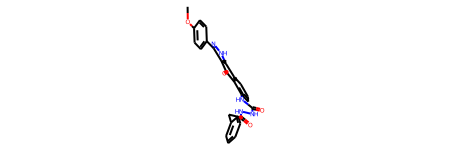

In [33]:
# get mol strucutre with lowest docking score in df_sample
df_sample.loc[df_sample['rock1_dockstring_score'].idxmin()]['Mol']